# Convolutional Neural Networks in hls4ml

In this notebook you will learn how to train a pruned and quantized convolutional neural network (CNN) and deploy it using hls4ml. For this exercise, we will use the Street View House Numbers (SVHN) Dataset (http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of real-world images of house numbers extracted from Google Street View images. The format is similar to that of the MNIST dataset, but is a much more challenging real-world problem, as illustrated by the examples shown below.

All the images are in RGB format and have been cropped to 32x32 pixels. 
Unlike MNIST, more than one digit can be present in the same image and in these cases, the center digit is used to assign a label to the image.
Each image can belong to one of 10 classes, corresponding to digits 0 through 9.

![alt text](images/test.png "SVHN examples from the test dataset")

The SVHN dataset consists of 73,257 images for training (and 531,131 extra samples that are easier to classify and can be used as additional training data) and 26,032 images for testing.

## Start with the neccessary imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Fetch the SVHN dataset using Tensorflow Dataset

In this part we will fetch the trainining, validation and test dataset using Tensorflow Datasets (https://www.tensorflow.org/datasets). We will not use the 'extra' training in order to save time, but you could fetch it by adding `split='train[:90%]+extra'`. We will use the first 90% of the training data for training and the last 10% for validation.

Training on 73257 samples of input shape (32, 32, 3), belonging to 10 classes


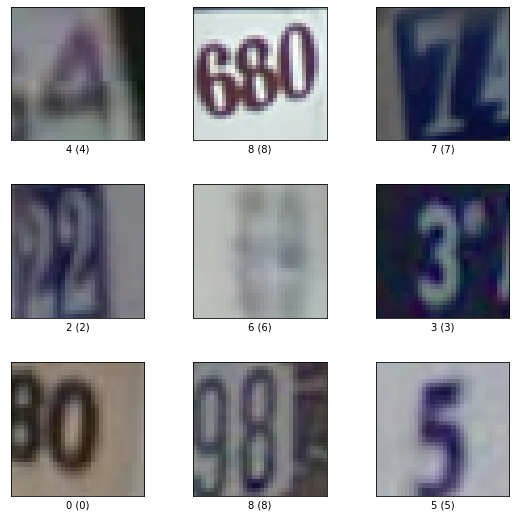

In [3]:
ds_train, info = tfds.load('svhn_cropped', split='train[:90%]', with_info=True, as_supervised=True,data_dir='/eos/home-t/thaarres/tensorflow_datasets/')
ds_test        = tfds.load('svhn_cropped', split='test', shuffle_files=True, as_supervised=True,data_dir='/eos/home-t/thaarres/tensorflow_datasets/')
ds_val         = tfds.load('svhn_cropped', split='train[-10%:]', shuffle_files=True, as_supervised=True,data_dir='/eos/home-t/thaarres/tensorflow_datasets/')

assert isinstance(ds_train, tf.data.Dataset)
train_size  = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape 
n_classes   = info.features['label'].num_classes 

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size,input_shape,n_classes))
fig = tfds.show_examples(ds_train, info)

We'll use TensorFlow Dataset to prepare our datasets. We'll fetch the training dataset as tuples, and the test dataset as numpy arrays

In [4]:
def preprocess(image, label,nclasses=10):
  image = tf.cast(image, tf.float32) / 255.
  label = tf.one_hot(tf.squeeze(label), nclasses)
  return image, label

In [5]:
batch_size = 1024

train_data = ds_train.map(preprocess,n_classes) #Get dataset as image and one-hot encoded labels, divided by max RGB   
train_data = train_data.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess,n_classes)    
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

# For  testing, we get the full dataset in memory as it's rather small.
# We fetch it as numpy arrays to have access to labels and images separately
X_test, Y_test = tfds.as_numpy(tfds.load('svhn_cropped',split='test',batch_size=-1,as_supervised=True,data_dir='/eos/home-t/thaarres/tensorflow_datasets/'))
X_test, Y_test = preprocess(X_test, Y_test,nclasses=n_classes)
print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape,Y_test.shape))

X train batch shape = (1024, 32, 32, 3), Y train batch shape = (1024, 10) 
X test batch shape = (26032, 32, 32, 3), Y test batch shape = (26032, 10) 


## Defining the model

We then need to define a model. For the lowest possible latency, each layer should have a maximum number of trainable parameters of 4096. This is due to fixed limits in the Vivado compiler, beyond which maximally unrolled (=parallel) compilation will fail. This will allow us to use `strategy = 'latency'` in the hls4ml part, rather than `strategy = 'resource'`, in turn resulting in lower latency

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

filters_per_conv_layer = [16,16,24]
neurons_per_dense_layer = [42,64]

x = x_in = Input(input_shape)
# x = BatchNormalization()(x)

for i,f in enumerate(filters_per_conv_layer):
    print( ('Adding convolutional block {} with N={} filters').format(i,f) )
    x = Conv2D(int(f), kernel_size=(3,3), strides=(1,1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), use_bias=False,
               name='conv_{}'.format(i))(x) 
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu',name='conv_act_%i'%i)(x)
    x = MaxPooling2D(pool_size = (2,2),name='pool_{}'.format(i) )(x)
x = Flatten()(x)

for i,n in enumerate(neurons_per_dense_layer):
  print( ('Adding dense block {} with N={} neurons').format(i,n) )
  x = Dense(n,kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001),name='dense_%i'%i, use_bias=False)(x)
  x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
  x = Activation('relu',name='dense_act_%i'%i)(x)
x = Dense(int(n_classes),name='output_dense')(x)
x_out = Activation('softmax',name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 30, 30, 16)        432       
_________________________________________________________________
bn_conv_0 (BatchNormalizatio (None, 30, 30, 16)        64        
_________________________________________________________________
conv_act_0 (Activation)      (None, 30, 30, 16)        0         
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 15, 15, 16)        0         
_______________________________

Lets check if this model can be implemented completely unrolled (=parallel)

In [7]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
           print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

conv_0: 432
conv_1: 2304
conv_2: 3456
dense_0: 4032
dense_1: 2688
output_dense: 640


Looks good! It's below the Vivado-enforced unroll limit of 4096.

## Prune dense and convolutional layers
Since we've seen in the previous notebooks that pruning can be done at no accuracy cost, let's prune the convolutional and dense layers to 50% sparsity, skipping the output layer

In [8]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size*0.9)  // batch_size #90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))

# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs, 
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.0,
                                                                   final_sparsity = 0.50, 
                                                                   begin_step = NSTEPS*2, 
                                                                   end_step = NSTEPS*10, 
                                                                   frequency = NSTEPS)
                     }
    if isinstance(layer, tf.keras.layers.Conv2D):
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

model_pruned = tf.keras.models.clone_model( model, clone_function=pruneFunction)

Number of training steps per epoch is 64
Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Please use `layer.add_weight` method instead.


## Train baseline

We're now ready to train the model! We defined the batch size and n epochs above. We won't use callbacks that store the best weights only, since this might select a weight configuration that has not yet reached 50% sparsity.

In [12]:
train = True # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 30

if train:
    
    LOSS        = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            pruning_callbacks.UpdatePruningStep()
            ] 

    start = time.time()
    model_pruned.fit(train_data,
                     epochs = n_epochs,
                     validation_data = val_data,
                     callbacks = callbacks)   
    end = time.time()

    print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
    model_pruned.save('pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
65/65 [==============================] - 2s 31ms/step - loss: 0.3468 - accuracy: 0.9143 - val_loss: 0.4497 - val_accuracy: 0.8821
Epoch 2/30
65/65 [==============================] - 2s 29ms/step - loss: 0.3390 - accuracy: 0.9156 - val_loss: 0.4459 - val_accuracy: 0.8836
Epoch 3/30
65/65 [==============================] - 2s 29ms/step - loss: 0.3615 - accuracy: 0.9110 - val_loss: 0.4874 - val_accuracy: 0.8771
Epoch 4/30
65/65 [==============================] - 2s 29ms/step - loss: 0.3415 - accuracy: 0.9179 - val_loss: 0.4637 - val_accuracy: 0.8792
Epoch 5/30
64/65 [============================>.] - ETA: 0s - loss: 0.3285 - accuracy: 0.9209
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00030000000260770325.
65/65 [==============================] - 2s 28ms/step - loss: 0.3285 - accuracy: 0.9208 - val_loss: 0.4527 - val_accuracy: 0.8852
Epoch 6/30
65/65 [==============================] - 2s 28ms/step - loss: 0.2990 - accuracy: 0.9316 - val_loss: 0.4117 - val_accurac

You'll notice the accuracy is lower than that in the hls4ml CNN paper (https://arxiv.org/abs/2101.05108) despite the model being the same. The reson for this is that we didn't use the ``extra`` training data in order to save time. If you want to futher optimize the network, increasing the training data is a good place to start. Enlarging the model architecture comes at a high latency/resource cost.

## Quantization and the fused Conv2D+BatchNormalization layer in QKeras
Let's now create a pruned an quantized model using QKeras. For this, we will use a fused Convolutional and BatchNormalization (BN) layer from QKeras, which will further speed up the implementation when we implement the model using hls4ml. 
There is currently no fused Dense+BatchNoralization layer available in QKeras, so we'll use Keras BatchNormalization when BN follows a Dense layer for now. We'll use the same precision everywhere, namely a bit width of 6 and 0 integer bits (this will be implemented as``<6,1>`` in hls4ml, due to the missing sign-bit). For now, make sure to set ```use_bias=True``` in ```QConv2DBatchnorm``` to avoid problems during synthesis.

In [109]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

x = x_in = Input(shape=input_shape)

for i,f in enumerate(filters_per_conv_layer):
    print( ('Adding fused QConv+BN block {} with N={} filters').format(i,f) )
    x = QConv2DBatchnorm(int(f), kernel_size=(3,3), strides=(1,1),
                         kernel_quantizer="quantized_bits(6,0,alpha=1)", 
                         bias_quantizer="quantized_bits(6,0,alpha=1)",
                         kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), use_bias=True,
                         name='fused_convbn_{}'.format(i))(x) 
    x = QActivation('quantized_relu(6)',name='conv_act_%i'%i)(x)
    x = MaxPooling2D(pool_size = (2,2),name='pool_{}'.format(i) )(x)
x = Flatten()(x)

for i,n in enumerate(neurons_per_dense_layer):
  print( ('Adding QDense block {} with N={} neurons').format(i,n) )
  x = QDense(n,
            kernel_quantizer="quantized_bits(6,0,alpha=1)",
            kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001),name='dense_%i'%i, use_bias=False)(x)
  x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
  x = QActivation('quantized_relu(6)',name='dense_act_%i'%i)(x)
x = Dense(int(n_classes),
           name='output_dense')(x)
x_out = Activation('softmax',name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()

Adding fused QConv+BN block 0 with N=16 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding fused QConv+BN block 2 with N=24 filters
Adding QDense block 0 with N=42 neurons
Adding QDense block 1 with N=64 neurons
Model: "qkeras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
fused_convbn_0 (QConv2DBatch (None, 30, 30, 16)        513       
_________________________________________________________________
conv_act_0 (QActivation)     (None, 30, 30, 16)        0         
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 15, 15, 16)        0         
_________________________________________________________________
fused_convbn_1 (QConv2DBatch (None, 13, 13, 16)        2385      
__________________________________

In [110]:
# Print the quantized layers
for layer in qmodel.layers:
    if hasattr(layer, "kernel_quantizer"):
        print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
    elif hasattr(layer, "quantizer"):
        print(layer.name, "quantizer:", str(layer.quantizer))

fused_convbn_0 kernel: quantized_bits(6,0,0,alpha=1) bias: quantized_bits(6,0,0,alpha=1)
conv_act_0 quantizer: quantized_relu(6,0)
fused_convbn_1 kernel: quantized_bits(6,0,0,alpha=1) bias: quantized_bits(6,0,0,alpha=1)
conv_act_1 quantizer: quantized_relu(6,0)
fused_convbn_2 kernel: quantized_bits(6,0,0,alpha=1) bias: quantized_bits(6,0,0,alpha=1)
conv_act_2 quantizer: quantized_relu(6,0)
dense_0 kernel: quantized_bits(6,0,0,alpha=1) bias: None
dense_act_0 quantizer: quantized_relu(6,0)
dense_1 kernel: quantized_bits(6,0,0,alpha=1) bias: None
dense_act_1 quantizer: quantized_relu(6,0)


You see that a bias quantizer is defined, although we are not using a bias term for the layers. This is set automatically by QKeras. In addition, you'll note that ``alpha='1'``. This sets the weight scale per channel to 1 (no scaling). The default is ``alpha='auto_po2'``, which sets the weight scale per channel to be a power-of-2, such that an actual hardware implementation can be performed by just shifting the result of the convolutional/dense layer to the right or left by checking the sign of the scale and then taking the log2 of the scale.

Let's now prune and train this model! If you want, you can also train the unpruned version, ``qmodel`` and see how the performance compares. We will stick to the pruned one here. Again, we do not use a model checkpoint which stores the best weights, in order to ensure the model is trained to the desired sparsity.

In [111]:
qmodel_pruned = tf.keras.models.clone_model( qmodel, clone_function=pruneFunction)

In [112]:
train = True

n_epochs = 30
if train:
    LOSS        = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True) 
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            pruning_callbacks.UpdatePruningStep()
            ]  

    start = time.time()
    history = qmodel_pruned.fit(train_data,
                          epochs = n_epochs,
                          validation_data = val_data,
                          callbacks = callbacks, 
                          verbose=1)     
    end = time.time()
    print('\n It took {} minutes to train!\n'.format( (end - start)/60.))

    qmodel_pruned.save('quantized_pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
65/65 [==============================] - 2s 38ms/step - loss: 2.1103 - accuracy: 0.3013 - val_loss: 2.2914 - val_accuracy: 0.1906
Epoch 2/30
65/65 [==============================] - 2s 33ms/step - loss: 1.3326 - accuracy: 0.6038 - val_loss: 2.2271 - val_accuracy: 0.2254
Epoch 3/30
65/65 [==============================] - 2s 33ms/step - loss: 0.9353 - accuracy: 0.7448 - val_loss: 2.0258 - val_accuracy: 0.3408
Epoch 4/30
65/65 [==============================] - 2s 32ms/step - loss: 0.7597 - accuracy: 0.7980 - val_loss: 1.6589 - val_accuracy: 0.4715
Epoch 5/30
65/65 [==============================] - 2s 33ms/step - loss: 0.7188 - accuracy: 0.8066 - val_loss: 1.4435 - val_accuracy: 0.5689
Epoch 6/30
65/65 [==============================] - 2s 31ms/step - loss: 0.6974 - accuracy: 0.8096 - val_loss: 1.0069 - val_accuracy: 0.7260
Epoch 7/30
65/65 [==============================] - 2s 32ms/step - loss: 0.6792 - accuracy: 0.8145 - val_loss: 1.3677 - val_accuracy: 0.5927
Epoch 8/30
65

We note that training a model quantization aware, takes around twice as long as when not quantizing during training!
The validation accuracy is very similar to that of the floating point model equivalent, despite containing significantly less information 

## Performance
Let's look at some ROC curves to compare the performance. Lets choose a few numbers so it doesn't get confusing. Feel free to change the numbers in ``labels``.

In [34]:
predict_baseline    = model_pruned.predict(X_test)
test_score_baseline = model_pruned.evaluate(X_test, Y_test)

predict_qkeras    = qmodel_pruned.predict(X_test)
test_score_qkeras = qmodel_pruned.evaluate(X_test, Y_test)

print('Keras accuracy = {} , QKeras 6-bit accuracy = {}'.format(test_score_baseline[1],test_score_qkeras[1]))

814/814 [==============================] - 3s 4ms/step - loss: 0.5280 - accuracy: 0.8623
Keras accuracy = 0.8907498717308044 , QKeras 6-bit accuracy = 0.8623232841491699


Plotting ROC for labels ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


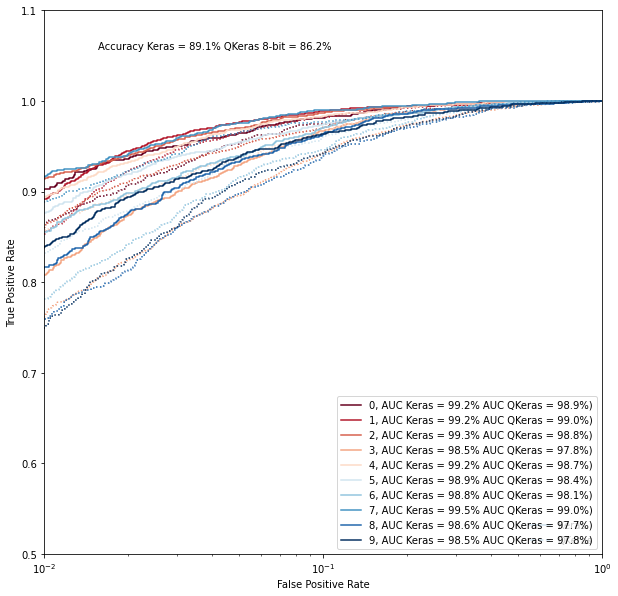

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


labels=['%i'%nr for nr in range (0,n_classes)] # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_q = pd.DataFrame()
fpr  = {}
tpr  = {}
auc1 = {}
fpr_q  = {}
tpr_q  = {}
auc1_q = {}
%matplotlib inline
colors  = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] = Y_test[:,int(label)]
    df[label + '_pred'] = predict_baseline[:,int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label],df[label+'_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])
    
    df_q[label] = Y_test[:,int(label)]
    df_q[label + '_pred'] = predict_qkeras[:,int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label],df_q[label+'_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])
    
    plt.plot(fpr[label],tpr[label]    ,label=r'{}, AUC Keras = {:.1f}% AUC QKeras = {:.1f}%)'.format(label,auc1[label]*100,auc1_q[label]*100), linewidth=1.5,c=colors[i],linestyle='solid')
    plt.plot(fpr_q[label],tpr_q[label], linewidth=1.5,c=colors[i],linestyle='dotted')

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01,1.)
plt.ylim(0.5,1.1)
plt.legend(loc='lower right')
plt.figtext(0.2, 0.83,r'Accuracy Keras = {:.1f}% QKeras 8-bit = {:.1f}%'.format(test_score_baseline[1]*100,test_score_qkeras[1]*100), wrap=True, horizontalalignment='left',verticalalignment='center')
from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['Keras', 'QKeras'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

The difference in AUC between the fp32 Keras model and the 8-bit QKeras model, is small, as we have seen for the previous examples. You can find a bonus exercise below, **Bonus: Automatic quantization**, where we'll use AutoQKeras to find the best heterogeneously quantized model, given a set of resource and accuracy constriants.
### Check sparsity
Let's also check the per-layer sparsity:

Layer prune_low_magnitude_conv_0: % of zeros = 0.5
Layer bn_conv_0: % of zeros = 0.0
Layer prune_low_magnitude_conv_1: % of zeros = 0.5
Layer bn_conv_1: % of zeros = 0.0
Layer prune_low_magnitude_conv_2: % of zeros = 0.5
Layer bn_conv_2: % of zeros = 0.0
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0
Layer prune_low_magnitude_fused_convbn_0: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_1: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_2: % of zeros = 0.5
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


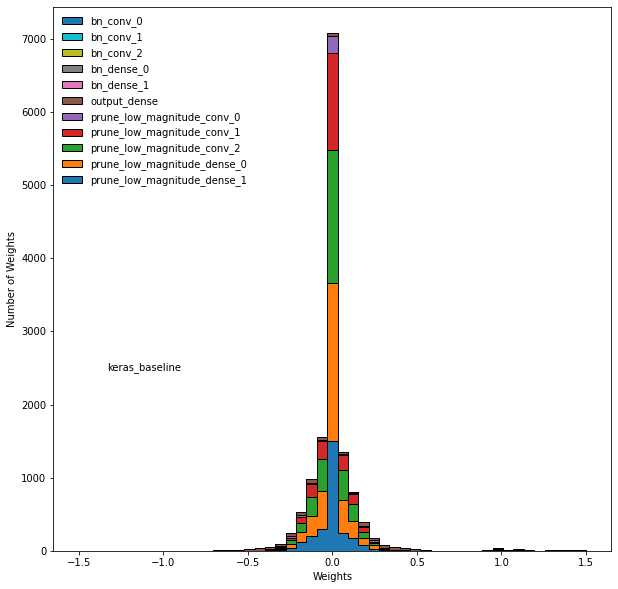

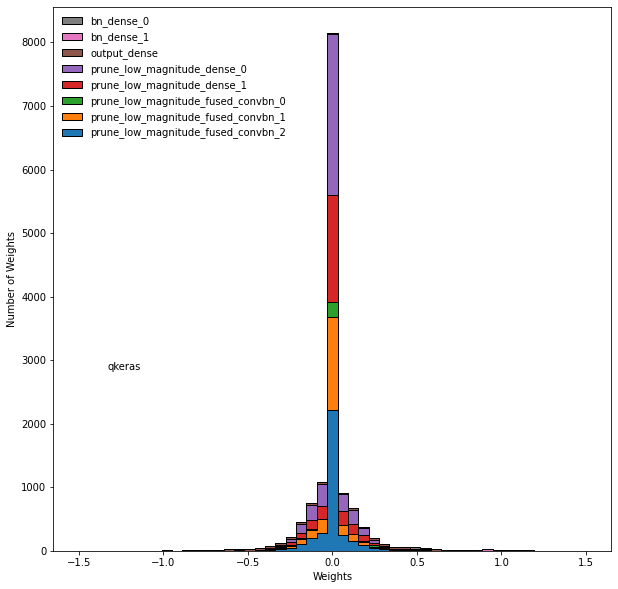

In [47]:
def doWeights(model):

  allWeightsByLayer = {}
  for layer in model.layers:
    if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
      continue 
    weights=layer.weights[0].numpy().flatten()  
    allWeightsByLayer[layer._name] = weights
    print('Layer {}: % of zeros = {}'.format(layer._name,np.sum(weights==0)/np.size(weights)))
  
  labelsW = []
  histosW = []

  for key in reversed(sorted(allWeightsByLayer.keys())):
    labelsW.append(key)
    histosW.append(allWeightsByLayer[key])

  fig = plt.figure(figsize=(10,10))
  bins = np.linspace(-1.5, 1.5, 50)
  plt.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW, edgecolor='black')
  plt.legend(frameon=False,loc='upper left')
  plt.ylabel('Number of Weights')
  plt.xlabel('Weights')
  plt.figtext(0.2, 0.38,model._name, wrap=True, horizontalalignment='left',verticalalignment='center')
    
doWeights(model_pruned) 
doWeights(qmodel_pruned) 

We see that 50% of the weights per layer are set to zero, as expected.
Now, let's synthesize the floating point Keras model and the QKeras quantized model!

## CNNs in hls4ml

In this part, we will take the two models we trained above (the floating-point 32 Keras model and the 6-bit QKeras model), and synthesize them with hls4ml. Although your models are probably already in memory, let's load them from scratch. We need to pass the appropriate custom QKeras/pruning layers when loading, and remove the pruning parameters that were saved together with the model.

In [100]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

model = tf.keras.models.load_model('pruned_cnn_model.h5',custom_objects={'PruneLowMagnitude': pruning_wrapper.PruneLowMagnitude,
                                                                         'QDense': QDense, 
                                                                         'QConv2DBatchnorm': QConv2DBatchnorm, 
                                                                         'QActivation': QActivation})
model  = strip_pruning(model)

qmodel = tf.keras.models.load_model('quantized_pruned_cnn_model.h5',custom_objects={'PruneLowMagnitude': pruning_wrapper.PruneLowMagnitude,
                                                                                    'QDense': QDense, 
                                                                                    'QConv2DBatchnorm': QConv2DBatchnorm, 
                                                                                    'QActivation': QActivation})
qmodel  = strip_pruning(qmodel)

Now, we need to define the hls4ml and Vivado configurations. Two things will change with respect to what was done in the previous exercises. First, we will use ``IOType= 'io_stream'`` in the Vivado configuration.

---
****You must use ``IOType= 'io_stream'`` if attempting to synthesize a convolutional neural network.****

---
The CNN implementation in hls4ml is based on streams, which are synthesized in hardware as first in, first out (FIFO) buffers. A sliding window buffer is used to hold all elements of a kernel window that are needed to compute one output element. We pre-compute the positions in the sliding window where a given input element isused, and store this information as a binary mask.

This is illustrated  in the gif below. The example shows a 3x3 convolution over a 6x6 image. The left image shows the mask of each pixel (we represent this as a number) and the right image shows the contents of the internal sliding window (an array of FIFOs, corresponding to the 3x3 kernel).

![alt text](images/conv2d_animation.gif "The implementation of convolutional layers in hls4ml is based on streams")

Lastly, we will use ``['Strategy'] = 'Latency'`` for all the layers in the hls4ml configuration. If one layer would have >4096 elements, we sould set ``['Strategy'] = 'Resource'`` for that layer, or increase the reuse factor by hand. You can find examples of how to do this below.

In [101]:
import hls4ml
import plotting

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)
  
cfg = hls4ml.converters.create_vivado_config()
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'pruned_cnn/'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: conv_0, layer type: Conv2D
  -> Activation (linear), layer name: conv_0
Layer name: bn_conv_0, layer type: BatchNormalization
Layer name: conv_act_0, layer type: Activation
Layer name: pool_0, layer type: MaxPooling2D
Layer name: conv_1, layer type: Conv2D
  -> Activation (linear), layer name: conv_1
Layer name: bn_conv_1, layer type: BatchNormalization
Layer name: conv_act_1, layer type: Activation
Layer name: pool_1, layer type: MaxPooling2D
Layer name: conv_2, layer type: Conv2D
  -> Activation (linear), layer name: conv_2
Layer name: bn_conv_2, layer type: BatchNormalization
Layer name: conv_act_2, layer type: Activation
Layer name: pool_2, layer type: MaxPooling2D
Layer name: dense_0, layer type: Dense
  -> Activation (linear), layer name: dense_0
Layer name: bn_dense_0, layer type: BatchNormalization
Layer name: dense_act_0, layer type: Activation
Layer name: dense_1, layer type: Dense
  -> Activation

Let's get a nice overview over the various shapes and precisions used for each layer through ``hls4ml.utils.plot_model``, as well as look at the weight profile using ``hls4ml.model.profiling.numerical``. The weight profiling returns two plots: Before (top) and after (bottom) various optimizations applied to the HLS model before the final translation to HLS, for instance the fusing of Dense and BatchNormalization layers.

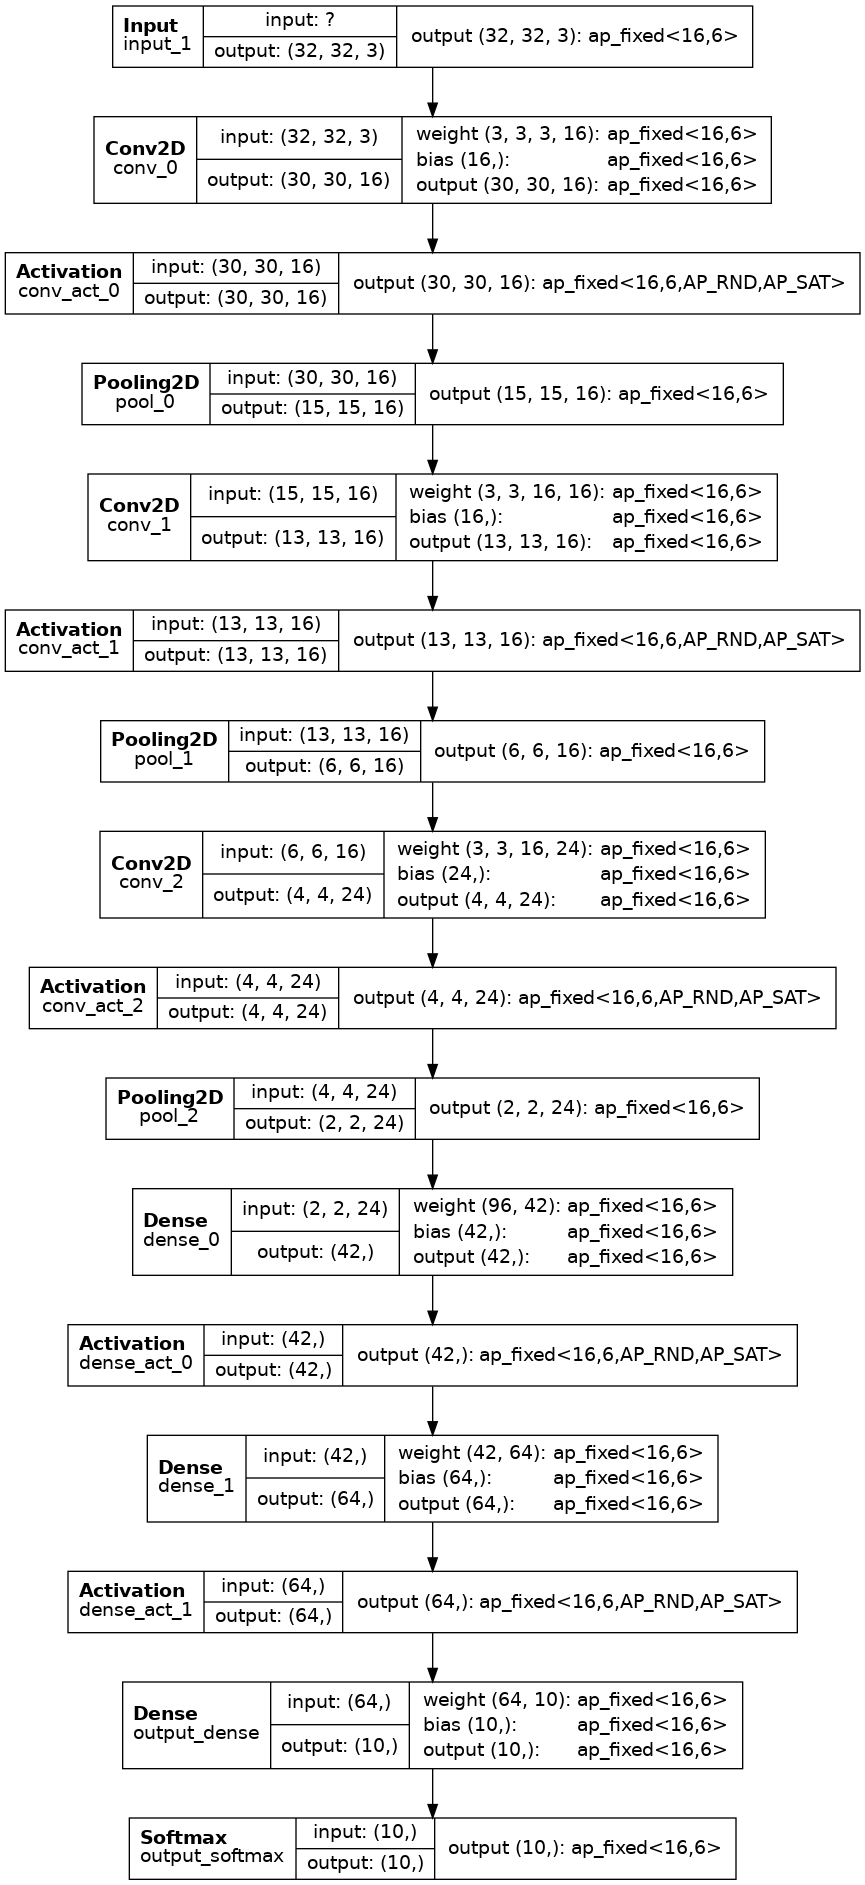

In [102]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, current shape: [[None, 32, 32, 3]]
Layer name: conv_0, layer type: Conv2D, current shape: [[None, 32, 32, 3]]
Layer name: bn_conv_0, layer type: BatchNormalization, current shape: [[None, 30, 30, 16]]
Layer name: conv_act_0, layer type: Activation, current shape: [[None, 30, 30, 16]]
Layer name: pool_0, layer type: MaxPooling2D, current shape: [[None, 30, 30, 16]]
Layer name: conv_1, layer type: Conv2D, current shape: [[None, 15, 15, 16]]
Layer name: bn_conv_1, layer type: BatchNormalization, current shape: [[None, 13, 13, 16]]
Layer name: conv_act_1, layer type: Activation, current shape: [[None, 13, 13, 16]]
Layer name: pool_1, layer type: MaxPooling2D, current shape: [[None, 13, 13, 16]]
Layer name: conv_2, layer type: Conv2D, current shape: [[None, 6, 6, 16]]
Layer name: bn_conv_2, layer type: BatchNormalization, current shape: [[None, 4, 4, 24]]
Layer name: conv_act_2, layer type: Activation, current shape: 

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 None,
 None)

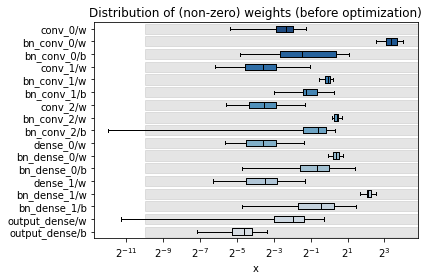

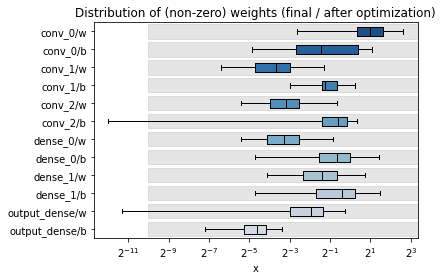

In [103]:
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)

The colored boxes are the distribution of the weights of the model, and the gray band illustrates the numerical range covered by the chosen fixed point precision. As we configured, this model uses a precision of ``ap_fixed<16,6>`` for all layers of the model. Let's now build our QKeras model

In [104]:
# Then the QKeras model
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls_config_q = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 1
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_q)
  
cfg_q = hls4ml.converters.create_vivado_config()
cfg_q['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg_q['HLSConfig']  = hls_config_q
cfg_q['KerasModel'] = qmodel
cfg_q['OutputDir']  = 'quantized_pruned_cnn/'
cfg_q['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

Interpreting Model
Topology:
Layer name: input_7, layer type: Input
Layer name: bn_input, layer type: BatchNormalization
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm
Layer name: conv_act_0, layer type: QActivation
Layer name: pool_0, layer type: MaxPooling2D
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm
Layer name: conv_act_1, layer type: QActivation
Layer name: pool_1, layer type: MaxPooling2D
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm
Layer name: conv_act_2, layer type: QActivation
Layer name: pool_2, layer type: MaxPooling2D
Layer name: dense_0, layer type: QDense
Layer name: bn_dense_0, layer type: BatchNormalization
Layer name: dense_act_0, layer type: QActivation
Layer name: dense_1, layer type: QDense
Layer name: bn_dense_1, layer type: BatchNormalization
Layer name: dense_act_1, layer type: QActivation
Layer name: output_dense, layer type: Dense
  -> Activation (linear), layer name: output_dense
Layer name: output_softmax, layer type: Activa

Let's plot the model and profile the weights her too

Interpreting Model
Topology:
Layer name: input_7, layer type: InputLayer, current shape: [[None, 32, 32, 3]]
Layer name: bn_input, layer type: BatchNormalization, current shape: [[None, 32, 32, 3]]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, current shape: [[None, 32, 32, 3]]
Name: quantized_relu
Layer name: conv_act_0, layer type: Activation, current shape: [[None, 30, 30, 16]]
Layer name: pool_0, layer type: MaxPooling2D, current shape: [[None, 30, 30, 16]]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, current shape: [[None, 15, 15, 16]]
Name: quantized_relu
Layer name: conv_act_1, layer type: Activation, current shape: [[None, 13, 13, 16]]
Layer name: pool_1, layer type: MaxPooling2D, current shape: [[None, 13, 13, 16]]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, current shape: [[None, 6, 6, 16]]
Name: quantized_relu
Layer name: conv_act_2, layer type: Activation, current shape: [[None, 4, 4, 24]]
Layer name: pool_2, layer type: MaxPooling2D, 

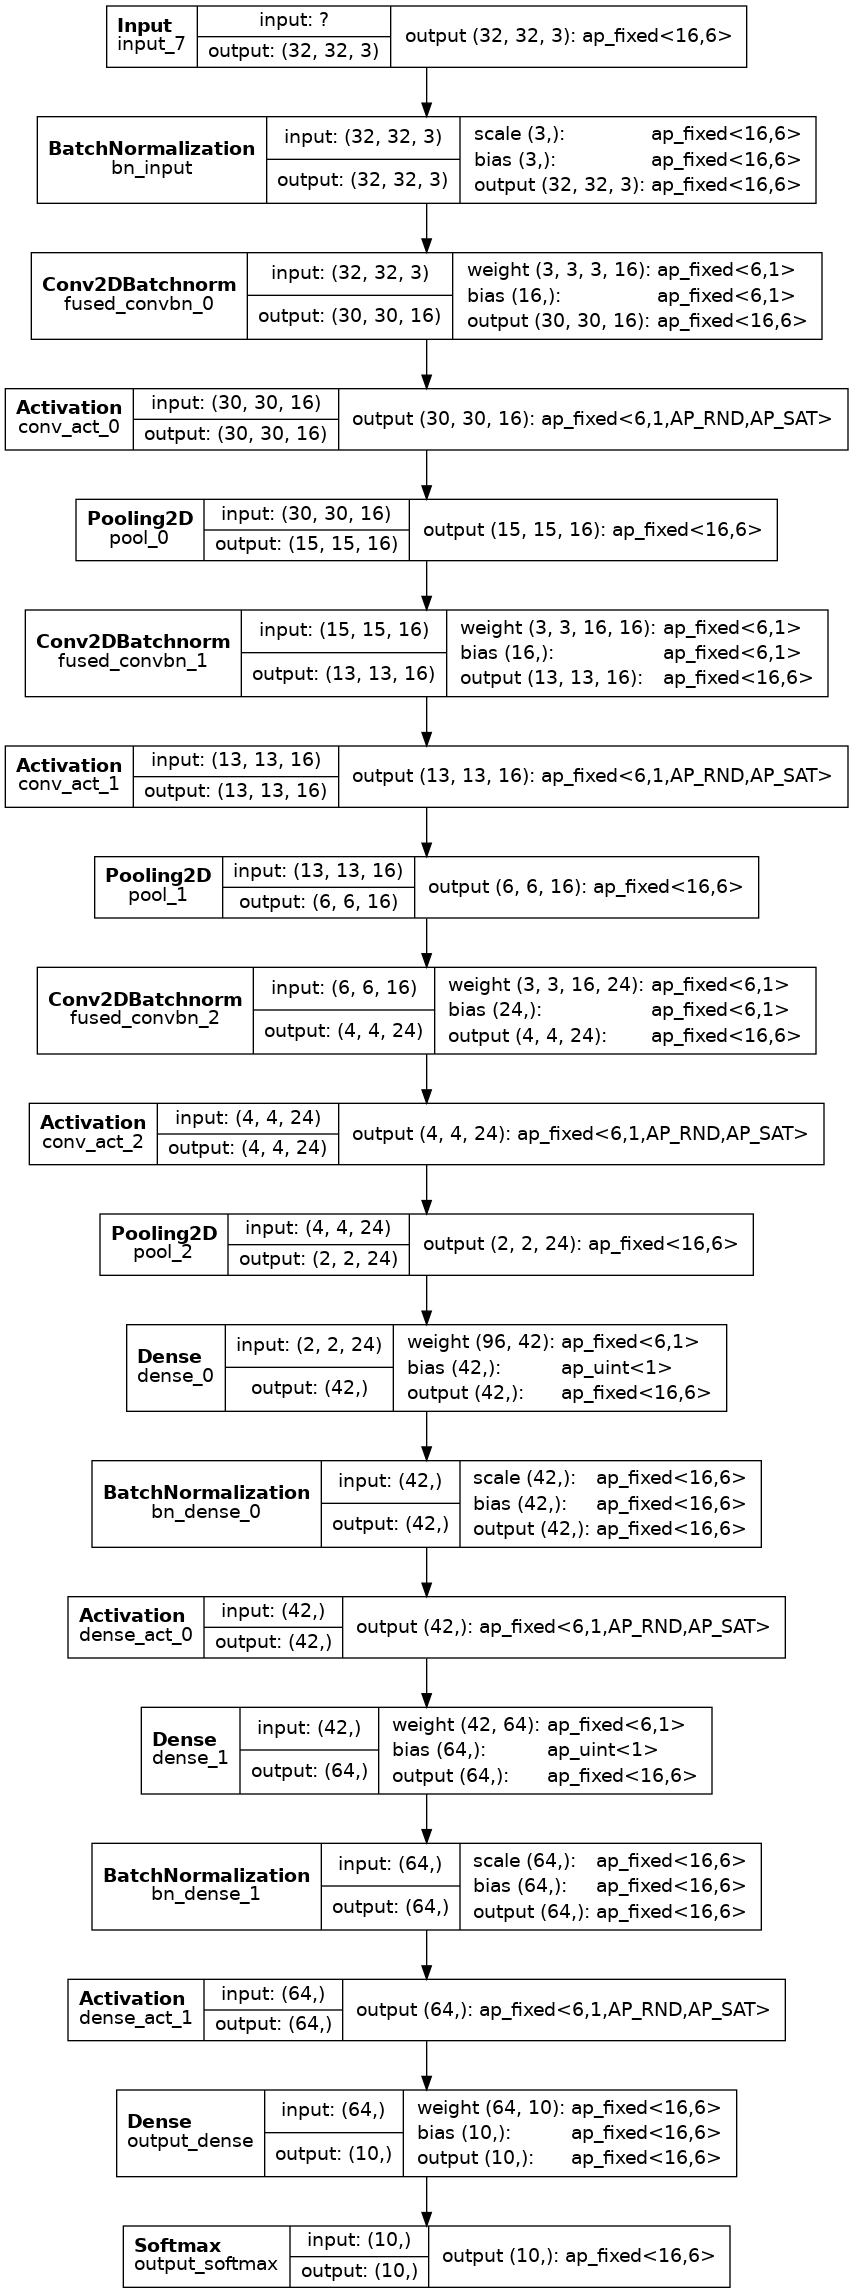

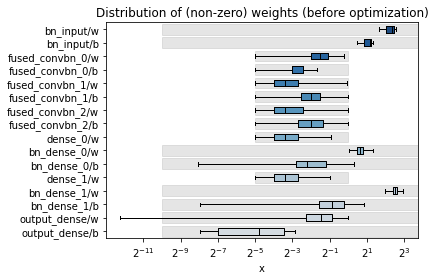

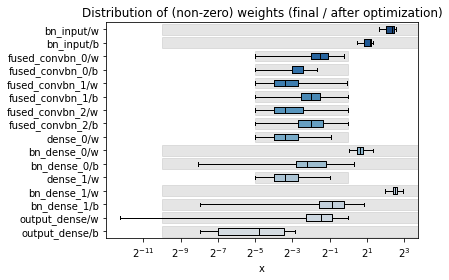

In [105]:
hls4ml.model.profiling.numerical(model=qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

For the 6-bit QKeras model, we see that different precisions are used for different layers. **NEED TO FIX THIS: conv bias is shown, correpsond to the fused BN? We might need to improve this in profiling.py, or clarify it here**

### Accuracy with bit-accurate emulation 
Let's check that the hls4ml accuracy matches the original. This usually takes some time, so let's do it over a reduced dataset

In [114]:
X_test_reduced = X_test[:1000]
Y_test_reduced = Y_test[:1000]

In [115]:
y_predict        = model.predict(X_test_reduced)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(X_test_reduced))

In [116]:
y_predict_q        = qmodel.predict(X_test_reduced)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(X_test_reduced))

Accuracy Keras:  0.893
Accuracy hls4ml: 0.8932
Accuracy Keras:  0.8645
Accuracy hls4ml: 0.8667


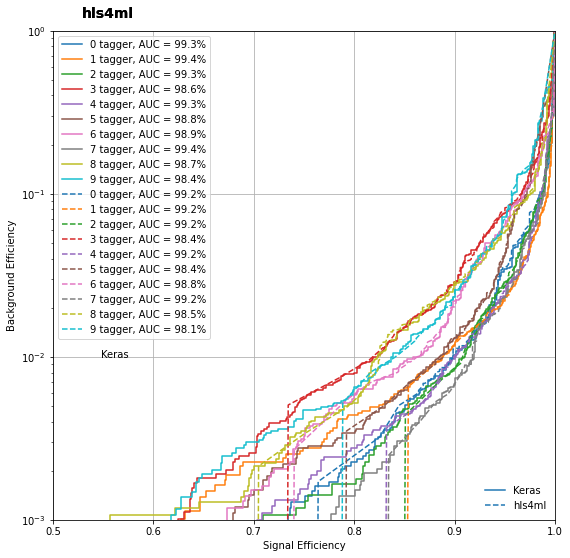

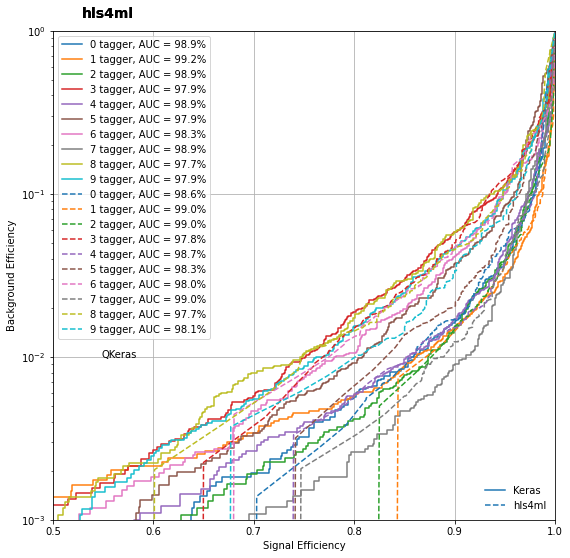

In [117]:
import plotting
from sklearn.metrics import accuracy_score

def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    
    accuracy_keras  = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred,axis=1)))
    accuracy_hls4ml = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1)))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred, labels=['%i'%nr for nr in range(n_classes)])
    plt.gca().set_prop_cycle(None) # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, labels=['%i'%nr for nr in range(n_classes)], linestyle='--')

    from matplotlib.lines import Line2D
    lines = [Line2D([0], [0], ls='-'),
             Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend
    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'],
                loc='lower right', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.38,label, wrap=True, horizontalalignment='left',verticalalignment='center')
    plt.ylim(0.01,1.)
    plt.xlim(0.5,1.)

# Plot the pruned floating point model:    
plotROC(Y_test_reduced,y_predict,y_predict_hls4ml,label="Keras") 

# Plot the pruned and quantized QKeras model
plotROC(Y_test_reduced,y_predict_q,y_predict_hls4ml_q,label="QKeras") 

Looks good! Let's synthesize the models. 
## Logic synthesis
As usual, this takes a while and you can follow the progress using ``tail -f pruned_cnn/vivado_hls.log`` and ``tail -f quantized_pruned_cnn/vivado_hls.log``.


In [ ]:
hls_model.build(csim=False, synth=True, vsynth=True)
hls_model_q.build(csim=False, synth=True, vsynth=True)

In [ ]:
We extract the latency from the C synthesis, namely the report in ```<project_dir>/myproject_prj/solution1/syn/report/myproject_csynth.rpt```. A more accurate latency estimate can be obtained from running cosim by passing ```hls_model.build(csim=False, synth=True, vsynth=True, cosim=True)``` ( = C/RTL cosimulation, synthesised HLS code is run on a simulator and tested on C test bench) but this takes a lot of time so we will skip it here.
The resource estimates are obtained from the Vivado logic synthesis, and can be extracted from the report in ```<project_dir>/vivado_synth.rpt```

In [ ]:
hls4ml.report.read_vivado_report('pruned_cnn/')
hls4ml.report.read_vivado_report('quantized_pruned_cnn/')

We see that the latency is of around 5 microseconds for both the quantized and the unquantized model, but that the resources are signifcantly reduced using QKeras.

Congratulations! You have now reached the end of this notebook. If you have some spare time, you can have a look at the bonus exercise below, where you will learn how to perform a bayesian optimization over the QKeras quantizers in order to obtain an optimally heterogeneously quantized model.

# Bonus exercise: Automatic quantization with AutoQKeras

In this bonus exercise, you will learn how to find the optimal heterogeneously quantized model using AutoQKeras.
For more details, you can look at the [AutoQKeras notebook](https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb). 

Let's first check the estimated energy consumption of the QKeras 8-bit model uisng QTools